In [1]:
from collections import defaultdict
import copy
import matplotlib.pyplot as plt
from circuit.parser import get_circuit_duration
import random
import numpy as np

from circuit import gen_random_circuits, label_ground_truth_fidelity
from upstream import RandomwalkModel
from downstream import FidelityModel
from simulator import NoiseSimulator
from utils.backend import devide_chip, gen_grid_topology, get_grid_neighbor_info, Backend, topology_to_coupling_map
from utils.backend import default_basis_single_gates, default_basis_two_gates
import pickle
import seaborn as sns
import pandas as pd

In [19]:
n_qubits_list = [50,100, 150, 200, 250, 300,350]#
paths = [
    f"simulate_50_350/{n_qubits}/error_params_predicts_{n_qubits}.pkl"
    for n_qubits in n_qubits_list
]


In [16]:
def plot_top_ratio(fig, axes,upstream_model, erroneous_pattern_weight):
    x ,y = [],[]
    
    erroneous_pattern_num = 0
    for device, erroneous_patterns in upstream_model.erroneous_pattern.items():
        erroneous_pattern_num += len(erroneous_patterns)
        
    total_path_num = sum([len(upstream_model.device2path_table[device]) for device in upstream_model.device2path_table])
        
    for top in range(1, 100,1):
        top /= 100
        total_find = 0
        for device, pattern_weights in erroneous_pattern_weight.items():
            path_table_size = len(upstream_model.device2path_table[device].keys())
            for pattern_weight in pattern_weights:
                if  pattern_weight[1] < top * path_table_size:
                    total_find += 1

   
        
        x.append(top * 100)
        y.append(total_find * 100 / erroneous_pattern_num)
        
        # x.append(total_path_num * top)
        # y.append(total_find)
        
    num_qubits = upstream_model.backend.n_qubits
        
    import matplotlib.pyplot as plt
    axes.plot(x, y ,markersize = 12,linewidth = 2, label=num_qubits)
    axes.set_xlabel('top')
    axes.set_ylabel('#find_path')
    # axes.set_ylabel('find_ratio')
    axes.legend() # 添加图例
    fig.show()

    return fig, axes

In [12]:
def find_error_path(upstream_model, error_params, name = None):
    error_params = np.array(error_params)
    erroneous_pattern = upstream_model.erroneous_pattern
    
    device_index2device = {} #两比特门与但单比特门映射为一维下标
    for device  in upstream_model.device2path_table.keys():
        device_index = list(upstream_model.device2path_table.keys()).index(device)
        device_index2device[device_index] = device
        
    error_params_path_weight = {} #训练好的参数对应的path及其权重
    error_params_path = {}
    for idx, device_error_param in enumerate(error_params):
        device = device_index2device[idx]
        sort = np.argsort(device_error_param)
        sort = sort[::-1]
        device_error_params_path_weight = []
        device_error_params_path = []
        for i in sort:
            if int(i) in upstream_model.device2reverse_path_table[device].keys():
                path = upstream_model.device2reverse_path_table[device][int(i)]
                if isinstance(path,str):
                    device_error_params_path_weight.append((path,device_error_param[i]))
                    device_error_params_path.append(path)
        error_params_path_weight[device] = device_error_params_path_weight
        error_params_path[device] = device_error_params_path
        
    erroneous_pattern_weight = {} #手动添加的error_path在训练完参数中的排位
    for device, patterns in erroneous_pattern.items():
        device_error_params_path = error_params_path[device]
        device_erroneous_pattern_weight = []
        for pattern in patterns:
            if pattern in device_error_params_path:
                k = device_error_params_path.index(pattern)
                device_erroneous_pattern_weight.append((pattern,k))
        erroneous_pattern_weight[device] = device_erroneous_pattern_weight
        
    return erroneous_pattern_weight

simulate_50_350/50/error_params_predicts_50.pkl
simulate_50_350/100/error_params_predicts_100.pkl
simulate_50_350/150/error_params_predicts_150.pkl
simulate_50_350/200/error_params_predicts_200.pkl
simulate_50_350/250/error_params_predicts_250.pkl
simulate_50_350/300/error_params_predicts_300.pkl
simulate_50_350/350/error_params_predicts_350.pkl


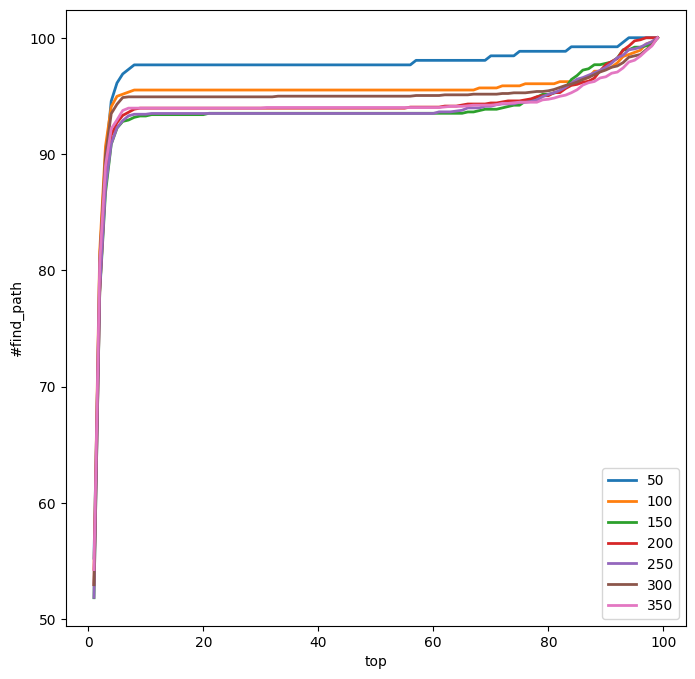

In [20]:
fig, axes = plt.subplots(figsize=(8,8)) # 创建一个图形对象和一个子图对象

for path,n_qubits in zip(paths,n_qubits_list):
    print(path)
    with open(path, "rb")as f:
        # pkl_result = pickle.load(f)
        # print(len(pkl_result))
        # downstream_model, test_dataset = pkl_result
        downstream_model, predicts, reals, durations, test_dataset = pickle.load(f)
        erroneous_pattern_weight = find_error_path(downstream_model.upstream_model, downstream_model.error_params['gate_params'])
        plot_top_ratio(fig, axes, downstream_model.upstream_model, erroneous_pattern_weight)


In [21]:

fig.savefig(f"find_ratio_percent_all.svg")


In [24]:
with open('opt_5bit/error_params_predicts_5.pkl', "rb")as f:
    downstream_model, predicts, reals, durations, test_dataset = pickle.load(f)
upstream_model = downstream_model.upstream_model

In [25]:
erroneous_pattern_weight = find_error_path(downstream_model.upstream_model, downstream_model.error_params['gate_params'])


In [31]:
erroneous_pattern_weight,upstream_model.erroneous_pattern

({0: [('ry,0-former-rx,0', 2),
   ('ry,0-parallel-cz,1,2', 5),
   ('ry,0-former-cz,1,2', 1)],
  1: [('ry,1-parallel-rx,2', 4),
   ('rx,1-former-cz,1,2', 1),
   ('ry,1-former-cz,1,2', 11),
   ('rx,1-parallel-ry,0', 0)],
  2: [('ry,2-parallel-ry,3', 3)],
  3: [('rx,3-former-rx,2', 2),
   ('rx,3-former-ry,4', 0),
   ('ry,3-former-ry,3', 5)],
  4: [('ry,4-former-ry,3', 7), ('rx,4-former-cz,2,3', 5)],
  (0, 1): [('cz,0,1-former-cz,2,3', 0), ('cz,0,1-former-ry,2', 1)],
  (1, 2): [('cz,1,2-former-ry,0', 0), ('cz,1,2-former-cz,1,2', 1)],
  (2, 3): [('cz,2,3-former-ry,4', 0),
   ('cz,2,3-former-rx,2', 2),
   ('cz,2,3-former-rx,3', 1)],
  (3, 4): []},
 defaultdict(list,
             {0: ['ry,0-former-rx,0',
               'ry,0-parallel-cz,1,2',
               'ry,0-former-cz,1,2'],
              1: ['ry,1-parallel-rx,2',
               'rx,1-former-cz,1,2',
               'ry,1-former-cz,1,2',
               'rx,1-parallel-ry,0'],
              2: ['ry,2-parallel-ry,3'],
              3: ['rx,3

In [36]:
top = 0.1
total_find = 0
# erroneous_pattern_num = 0
# for device, erroneous_patterns in upstream_model.erroneous_pattern.items():
#     erroneous_pattern_num += len(erroneous_patterns)
for device, pattern_weights in erroneous_pattern_weight.items():
    path_table_size = len(upstream_model.device2path_table[device].keys())
    for pattern_weight in pattern_weights:
        if  pattern_weight[1] < top * path_table_size:
            total_find += 1
            print(device, pattern_weight[0])


0 ry,0-former-rx,0
0 ry,0-former-cz,1,2
1 ry,1-parallel-rx,2
1 rx,1-former-cz,1,2
1 rx,1-parallel-ry,0
2 ry,2-parallel-ry,3
3 rx,3-former-rx,2
3 rx,3-former-ry,4
3 ry,3-former-ry,3
(0, 1) cz,0,1-former-cz,2,3
(0, 1) cz,0,1-former-ry,2
(1, 2) cz,1,2-former-ry,0
(1, 2) cz,1,2-former-cz,1,2
(2, 3) cz,2,3-former-ry,4
(2, 3) cz,2,3-former-rx,2
(2, 3) cz,2,3-former-rx,3


In [ ]:
{0: ['ry,0-parallel-cz,1,2'],
1: ['ry,1-former-cz,1,2'],
4: ['ry,4-former-ry,3', 'rx,4-former-cz,2,3']}